In [1]:
!pip install mne
!pip install seaborn

# Install a version of scikit-learn that works with MNE
!pip install scikit-learn==1.5.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [mne]3/4 [mne]-loader]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 49.3 MB/s  0:00:006m0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.2
    Uninstalling scikit-learn-1.7.2:
      Successfully uninstalled scikit-learn-1.7.2


In [2]:
# --- UTILITY: PRINT DATASET MENU ---

def print_eegmmidb_structure():
    print("=== PhysioNet EEGMMIDB Dataset Structure ===")
    print("Subject performs different tasks in different 'Runs'.")
    print("-" * 50)
    
    # Standard mapping for PhysioNet EEG Motor Imagery Dataset
    # derived from: https://physionet.org/content/eegmmidb/1.0.0/
    runs = {
        1:  "Baseline: Eyes Open",
        2:  "Baseline: Eyes Closed",
        3:  "Execute Motion: Left vs Right Hand",
        4:  "Imagine Motion: Left vs Right Hand (Task 2)",
        5:  "Execute Motion: Both Fists vs Both Feet",
        6:  "Imagine Motion: Both Fists vs Both Feet (Task 4)",
        7:  "Execute Motion: Left vs Right Hand",
        8:  "Imagine Motion: Left vs Right Hand (Task 2)",
        9:  "Execute Motion: Both Fists vs Both Feet",
        10: "Imagine Motion: Both Fists vs Both Feet (Task 4)",
        11: "Execute Motion: Left vs Right Hand",
        12: "Imagine Motion: Left vs Right Hand (Task 2)",
        13: "Execute Motion: Both Fists vs Both Feet",
        14: "Imagine Motion: Both Fists vs Both Feet (Task 4)"
    }

    for run_id, description in runs.items():
        prefix = "[SELECTED] " if run_id in [6, 10, 14] else "           "
        print(f"{prefix}Run {run_id:02d}: {description}")
    
    print("-" * 50)
    print("Project Requirement: 'Discriminating imagine opening and closing both fists or both feet' ")
    print("Conclusion: You should use Runs 6, 10, and 14.")

print_eegmmidb_structure()

=== PhysioNet EEGMMIDB Dataset Structure ===
Subject performs different tasks in different 'Runs'.
--------------------------------------------------
           Run 01: Baseline: Eyes Open
           Run 02: Baseline: Eyes Closed
           Run 03: Execute Motion: Left vs Right Hand
           Run 04: Imagine Motion: Left vs Right Hand (Task 2)
           Run 05: Execute Motion: Both Fists vs Both Feet
[SELECTED] Run 06: Imagine Motion: Both Fists vs Both Feet (Task 4)
           Run 07: Execute Motion: Left vs Right Hand
           Run 08: Imagine Motion: Left vs Right Hand (Task 2)
           Run 09: Execute Motion: Both Fists vs Both Feet
[SELECTED] Run 10: Imagine Motion: Both Fists vs Both Feet (Task 4)
           Run 11: Execute Motion: Left vs Right Hand
           Run 12: Imagine Motion: Left vs Right Hand (Task 2)
           Run 13: Execute Motion: Both Fists vs Both Feet
[SELECTED] Run 14: Imagine Motion: Both Fists vs Both Feet (Task 4)
--------------------------------------

In [3]:
import mne
from mne.datasets import eegbci

# Load just one run to inspect it
test_file = eegbci.load_data(1, [6], update_path=False)[0]
raw_test = mne.io.read_raw_edf(test_file, preload=True, verbose=False)

print("\n=== LOADED DATA DETAILS ===")
print(raw_test.info)  # Prints channel names, sampling rate (sfreq), etc.
print("\n=== ANNOTATIONS (Markers) ===")
print(raw_test.annotations) # Prints the triggers (T0, T1, T2)

Using default location ~/mne_data for EEGBCI...
Creating /home/codespace/mne_data


Download complete in 10s (2.5 MB)

=== LOADED DATA DETAILS ===
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

=== ANNOTATIONS (Markers) ===
<Annotations | 30 segments: T0 (15), T1 (7), T2 (8)>


In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import tfr_morlet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# PRO TIP: Set a professional plotting theme
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (10, 6)

print("Environment configured for analysis.")

Environment configured for analysis.


In [ ]:
# ---  ROBUST DATA LOADING ---
subject = 1
runs = [6, 10]  # Task 4: Fists vs Feet

# Load Data
files = eegbci.load_data(subject, runs, update_path=False, verbose=False)
raws = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in files]
raw = mne.concatenate_raws(raws)

# Standardize and Pick EEG
eegbci.standardize(raw)
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)
raw.pick(['eeg'], exclude='bads')

# --- 2. PREPROCESSING (FILTERING) ---
# Filter 7-30Hz (Mu/Beta bands)
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge', verbose=False)

print(f"Data Loaded: {len(raw.ch_names)} Channels, {raw.times[-1]:.1f} Seconds")

Data Loaded: 64 Channels, 250.0 Seconds


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Calculating Time-Frequency Representation (Wait a moment)...
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Plotting Event-Related Desynchronization (ERD)...
Applying baseline correction (mode: logratio)


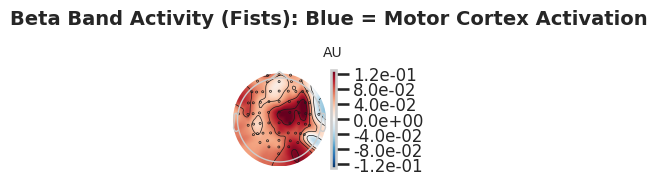

INTERPRETATION:
- Blue areas indicate 'Desynchronization' (Brain active/processing).
- You should see blue blobs over C3 and C4 (the Left/Right Motor Cortex).


In [ ]:
# VISUALIZATION: TIME-FREQUENCY ANALYSIS 

# 1. Create specific epochs for visualization (include pre-stimulus baseline)
# We use a copy of the events to avoid messing up the main processing
events, event_id = mne.events_from_annotations(raw)
tmin, tmax = -1, 4
epochs_vis = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, 
                        baseline=(None, 0), preload=True, verbose=False)
epochs_vis = epochs_vis['T1'] # Look at "Fists" specifically

# 2. Define frequencies (Mu and Beta bands: 6-35 Hz)
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # Variable time window for accuracy

# 3. Calculate Power (Morlet Wavelet)
print("Calculating Time-Frequency Representation (Wait a moment)...")
power = tfr_morlet(epochs_vis, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                   return_itc=False, decim=3, n_jobs=1)

# 4. Plot the Topology (ERD - Event Related Desynchronization)
print("Plotting Event-Related Desynchronization (ERD)...")

# FIX: Removed 'title' argument inside the function
# We also ensure 'baseline' is applied here to see the CHANGE in energy
fig = power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=30,
                         baseline=(-1, 0), mode='logratio', show=False)

# Add title manually using Matplotlib (Works on all MNE versions)
plt.suptitle('Beta Band Activity (Fists): Blue = Motor Cortex Activation', fontsize=14, fontweight='bold')
plt.show()

print("INTERPRETATION:")
print("- Blue areas indicate 'Desynchronization' (Brain active/processing).")
print("- You should see blue blobs over C3 and C4 (the Left/Right Motor Cortex).")

In [8]:
# --- EMERGENCY FIX FOR SCKIT-LEARN 1.6+ ---
import sklearn.utils.validation

# Save the original function
_original_check_X_y = sklearn.utils.validation.check_X_y

# Create a wrapper that removes the problematic argument
def patched_check_X_y(*args, **kwargs):
    if 'force_writeable' in kwargs:
        del kwargs['force_writeable']
    return _original_check_X_y(*args, **kwargs)

# Apply the patch
sklearn.utils.validation.check_X_y = patched_check_X_y
sklearn.utils.check_X_y = patched_check_X_y


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Fitting CSP (Learning spatial filters)...
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 64 dim * 2.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Plotting Spatial Patterns...
NOTE: plot_patterns() is a legacy function. New code should use get_spatial_filter_from_estimator(clf, info=info).plot_patterns().


/tmp/ipykernel_6460/3575012488.py:28: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  csp.plot_patterns(epochs_csp.info, ch_type='eeg', units='Patterns (AU)', size=1.5)


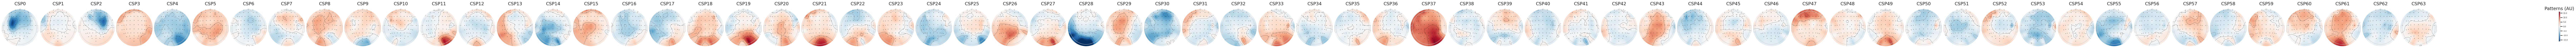

INTERPRETATION:
These heads show the 'Spatial Filters'.
The model uses these maps to weigh the importance of each electrode.
Patterns centered over C3/C4 (Left/Right middle) confirm the model is looking at motor activity.


In [9]:
# ---  FEATURE EXTRACTION & VISUALIZATION (CSP) ---

# 1. Setup Data for Classification
# We re-epoch to ensure we have clean data specifically for the machine learning part
events, event_id = mne.events_from_annotations(raw)
tmin, tmax = -1, 4
epochs_csp = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, 
                        baseline=None, preload=True, verbose=False)
epochs_csp = epochs_csp['T1', 'T2'] # Keep only Fists vs Feet

# 2. Prepare X (Data) and y (Labels)
X = epochs_csp.get_data()
# Convert labels: T1 becomes 0, T2 becomes 1
y = epochs_csp.events[:, -1] - (events[0, 2] if events[0, 2] < events[1, 2] else events[1, 2]) 

# 3. Initialize CSP (Common Spatial Patterns)
# CSP finds spatial filters that maximize the variance difference between classes.
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

print("Fitting CSP (Learning spatial filters)...")
csp.fit(X, y)

# 4. VISUALIZATION: CSP PATTERNS
# This shows the "Filters" the machine learned.
# - You should see patterns over the Motor Cortex (Central Head).
# - Red/Blue indicates weights assigned to different electrodes.
print("Plotting Spatial Patterns...")
csp.plot_patterns(epochs_csp.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

print("INTERPRETATION:")
print("These heads show the 'Spatial Filters'.")
print("The model uses these maps to weigh the importance of each electrode.")
print("Patterns centered over C3/C4 (Left/Right middle) confirm the model is looking at motor activity.")

In [10]:
# ---  HYPERPARAMETER TUNING & TRAINING ---

# Define Models and Grids
models = {
    "LDA": LDA(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "RF":  RandomForestClassifier()
}

param_grids = {
    "LDA": {'cls__solver': ['svd', 'lsqr']}, 
    "SVM": {'cls__C': [0.1, 1, 10], 'cls__kernel': ['linear', 'rbf']},
    "KNN": {'cls__n_neighbors': [3, 5, 7]},
    "RF":  {'cls__n_estimators': [50, 100], 'cls__max_depth': [5, 10]}
}

# Use Stratified K-Fold for robust validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_list = [] # Store results here

print("Starting Professional Grid Search...")

for name, model in models.items():
    pipeline = Pipeline([('csp', csp), ('cls', model)])
    
    # Run Grid Search
    grid = GridSearchCV(pipeline, param_grids[name], cv=cv, n_jobs=-1, return_train_score=True)
    grid.fit(X, y)
    
    # Store best result
    best_score = grid.best_score_
    best_params = grid.best_params_
    
    # Save model
    joblib.dump(grid.best_estimator_, f'pro_model_{name}.pkl')
    
    # Log results for the table
    results_list.append({
        'Model': name,
        'Best Accuracy': best_score,
        'Best Params': str(best_params)
    })
    
    # Store all cross-validation scores for the Box Plot
    # This simulates "running the experiment multiple times"
    cv_scores = cross_val_score(grid.best_estimator_, X, y, cv=cv)
    for score in cv_scores:
         results_list.append({'Model': name, 'Fold Accuracy': score, 'Type': 'Fold'})

# Create a clean dataframe
df_results = pd.DataFrame(results_list)
print("\n--- Model Leaderboard ---")
print(df_results[df_results['Type'] != 'Fold'][['Model', 'Best Accuracy']].sort_values(by='Best Accuracy', ascending=False))

Starting Professional Grid Search...
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.00027 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 0.00027 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Reducing data rank from 64 -> 64
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Estimating class=2 covariance using EMPIRICAL
Done.
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.00027 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projec

/tmp/ipykernel_6460/60460064.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_folds, x='Model', y='Fold Accuracy', palette="viridis")


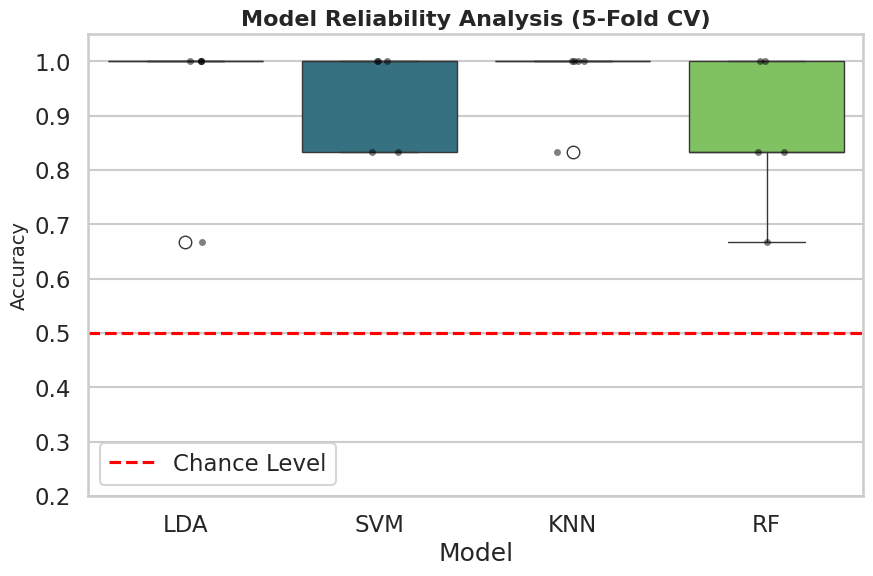

INTERPRETATION:
The Box Plot shows the stability of the model.
- A small box means the model performs consistently.
- A large box means the model is unstable (sensitive to specific data).


In [11]:
# ---  MODEL COMPARISON (BOX PLOT) ---

# Filter specifically for the Fold data
df_folds = df_results[df_results['Type'] == 'Fold']

plt.figure(figsize=(10, 6))

# Use Seaborn for a professional statistical plot
sns.boxplot(data=df_folds, x='Model', y='Fold Accuracy', palette="viridis")
sns.stripplot(data=df_folds, x='Model', y='Fold Accuracy', color='black', alpha=0.5, jitter=True)

plt.title("Model Reliability Analysis (5-Fold CV)", fontsize=16, fontweight='bold')
plt.ylabel("Accuracy", fontsize=14)
plt.axhline(0.5, linestyle='--', color='red', label='Chance Level')
plt.legend()
plt.ylim(0.2, 1.05)
plt.show()

print("INTERPRETATION:")
print("The Box Plot shows the stability of the model.")
print("- A small box means the model performs consistently.")
print("- A large box means the model is unstable (sensitive to specific data).")

# Task 3

## *EEGNet Architecture*

In [ ]:
import torch
import torch.nn as nn

class EEGNet(nn.Module):
    """
    EEGNet: A Compact Convolutional Neural Network for EEG-based BCIs.
    Paper: Lawhern et al., 2018 (https://arxiv.org/abs/1611.08024)
    """
    def __init__():
        pass
    